# Polluting Weather
by Will Rosenfeld

# Abstract
Objective: To understand the role weather plays in driving air quality levels in Los Angeles.

Data:
    1. EPA Air Quality Index Daily Values Report (2008-2017): 
        - Location: https://www.epa.gov/outdoor-air-quality-data/air-quality-index-report
        - Documentation: https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports#aqidaily
    2. NOAA US Daily Weather Data (2010-2017): 
        - Location: https://www.epa.gov/outdoor-air-quality-data/air-quality-index-daily-values-report
        - Documentation: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf
Method:
    - Target: Air Quality Index (https://en.wikipedia.org/wiki/Air_quality_index#United_States) will serve as a strong predictor variable
    - Predictors: Temp, Precip, Wind, Clouds, etc.

# Imports

In [1]:
# General
import pandas as pd
import numpy as np
import math
from datetime import datetime
from sklearn import metrics
# Selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
# Import EPA Daily Air Quality Index data for Los Angeles
pol_path = '/Users/wtrosenfeld/Google Drive/WTR Personal Files/Learning/Post Grad/General Assembly/ds-dc-22/5_final-projects/Polluting Weather/Data/EPA/'
la08 = pd.DataFrame.from_csv(pol_path + 'aqidaily2008.csv')
la09 = pd.DataFrame.from_csv(pol_path + 'aqidaily2009.csv')
la10 = pd.DataFrame.from_csv(pol_path + 'aqidaily2010.csv')
la11 = pd.DataFrame.from_csv(pol_path + 'aqidaily2011.csv')
la12 = pd.DataFrame.from_csv(pol_path + 'aqidaily2012.csv')
la13 = pd.DataFrame.from_csv(pol_path + 'aqidaily2013.csv')
la14 = pd.DataFrame.from_csv(pol_path + 'aqidaily2014.csv')
la15 = pd.DataFrame.from_csv(pol_path + 'aqidaily2015.csv')
la16 = pd.DataFrame.from_csv(pol_path + 'aqidaily2016.csv')
la17 = pd.DataFrame.from_csv(pol_path + 'aqidaily2017.csv')
#perhaps use instead: pd.read_csv(url, index_col='datetime', parse_dates=True)

frames = [la08,la09,la10,la11,la12,la13,la14,la15,la16,la17]
pol = pd.concat(frames)

In [3]:
# Import NOAA Daily Weather data for Los Angeles
wea_path = '/Users/wtrosenfeld/Google Drive/WTR Personal Files/Learning/Post Grad/General Assembly/ds-dc-22/5_final-projects/Polluting Weather/Data/NOAA/'
wea = pd.DataFrame.from_csv(wea_path + '1106788.csv')

In [4]:
# Import EPA Historical Next Day AQI Forecasts for Los Angeles
pfr_path = '/Users/wtrosenfeld/Google Drive/WTR Personal Files/Learning/Post Grad/General Assembly/ds-dc-22/5_final-projects/Polluting Weather/Data/EPA/'
pfr = pd.DataFrame.from_csv(pfr_path + 'aqinextdayforecast2010_2017.csv')

# Data Preparation

In [5]:
# Reformat AQI data
pol.reset_index(inplace=True)
pol.columns = ['DATE','MAIN_POLLUTANT','AQI','CO','SO2','NO2','OZONE','PM10','PM25']
print(pol.shape)

(3469, 9)


In [6]:
# Reformat and Filter Weather data
wea.reset_index(inplace=True)
wea = wea[wea['STATION'] == 'USW00093134']
wea['DATE'] = pd.to_datetime(wea['DATE'])

In [7]:
# Reformat and filter forecast data
pfr.reset_index(inplace=True)
pfr = pfr[pfr['ForecastPeriod'] == 'Next Day']
pfr['DATE'] = pd.to_datetime(pfr['ForecastDate'])
pfr = pfr.pivot(index='DATE', columns='Parameter', values='AQI')
pfr.reset_index(inplace=True)
pfr['AQI_fore'] = pfr[['CO','NO2','OZONE','PM10','PM2.5']].max(axis=1)
pfr.drop(['CO','NO2','OZONE','PM10','PM2.5'], axis=1, inplace=True)
print(pfr.shape)

(2872, 2)


In [8]:
# Join pollution and weather data
pw = pd.merge(wea,pol,how='inner',left_on=wea['DATE'],right_on=pol['DATE'])
pw["DATE"] = pw['DATE_x']
pw.drop(['DATE_x','DATE_y'], axis=1, inplace=True)
print(pw.shape)

(3469, 66)


In [9]:
# Left join pollution forecast data
pw = pd.merge(pw,pfr,how='left', on='DATE')
print(pw.shape)

(3469, 67)


# Feature Engineering

In [10]:
# Check for nulls
pw.isnull().sum(); #remove ";" to see results

In [11]:
# Date features
pw['YEAR'] = pd.DatetimeIndex(pw['DATE']).year
pw['DOW'] = pd.DatetimeIndex(pw['DATE']).weekday
pw['WEEKDAY'] = pw['DOW'].map({0:1,1:1,2:1,3:1,4:1,5:0,6:0}) #0=monday

In [12]:
# Weather features

#temperature
pw['TEMP_avg'] = (pw['TMAX'] + pw['TMIN']) / 2
pw['TEMP_rng'] = pw['TMAX']- pw['TMIN']
pw.rename(columns={'TMIN':'TEMP_min'}, inplace=True)
pw.rename(columns={'TMAX':'TEMP_max'}, inplace=True)
#percipitation
pw['PRCP_bin'] = np.where(pw['PRCP'] > 0,1,0)
#wind
pw['WIND_Uwe'] = (-np.sin(np.radians(pw['WDF5'])) * pw['WSF5'])
pw['WIND_Vns'] = (np.cos(np.radians(pw['WDF5'])) * pw['WSF5'])
pw['WIND_bin'] = np.where(pw['AWND'] > 1,1,0)
pw.rename(columns={'AWND':'WIND_avg'}, inplace=True)
pw.rename(columns={'WSF5':'WIND_max'}, inplace=True)
#NOTE
# Weather forecast data would be preferable to weather data due to time consistency issues
# Lags were not used as weather forecasts are quite reliable 24 hours in advance
# This is dynamic creates a time inconsistency issue that slightly overstates the model's power

In [13]:
# Pollution features (withheld for weather analysis)
pol_lags = ['AQI','CO','NO2','OZONE','PM10','PM25'] #excluding SO2
for col in pol_lags:
    pw[col+'_lag'] = pw[col].shift(1)
pw['AQI_mov'] = pd.Series.ewm(pw['AQI_lag'], span=5).mean()

In [14]:
# Seasonality features (withheld for weather analysis)
pw['MONTH'] = pd.DatetimeIndex(pw['DATE']).month
pw['WEEK'] = pd.DatetimeIndex(pw['DATE']).week
pw['WEEK_quad'] = pw['WEEK']**2
pw.shape

(3469, 86)

# Feature Metrics & Visualizations

In [15]:
# Variance of AQI by YEAR
pw.groupby('YEAR').AQI.agg(['mean', 'std'])

,mean,std
YEAR,,
2008,95.658470,43.175599
2009,92.276712,40.896044
2010,86.509589,33.729337
2011,92.150685,37.398313
2012,91.740437,37.168271
2013,87.375342,33.048482
2014,89.704110,33.872419
2015,91.287671,37.299014
2016,85.387978,35.005475


In [16]:
# Variance of AQI by YEAR
pw.groupby('MONTH').AQI.agg(['mean', 'std'])

,mean,std
MONTH,,
1,74.103226,23.643023
2,66.932862,21.872432
3,69.870968,20.231735
4,78.510000,25.892947
5,93.422581,36.736164
6,122.150000,42.296780
7,122.960573,37.213682
8,124.795699,37.891143
9,104.070370,35.554015


In [17]:
# Drivers of AQI
pw.groupby('MAIN_POLLUTANT').AQI.count()

MAIN_POLLUTANT
NO2       291
Ozone    1607
PM10       23
PM2.5    1547
SO2         1
Name: AQI, dtype: int64

# Feature Selection

In [18]:
# Select features
tim_cols = ['YEAR','WEEKDAY']
wea_cols = ['TEMP_avg','TEMP_rng','PRCP_bin','WIND_avg','WIND_Uwe','WIND_Vns']
pol_cols = ['AQI_lag','CO_lag','NO2_lag','OZONE_lag','PM10_lag','PM25_lag']
snn_cols = ['WEEK','WEEK_quad']

feature_cols = ['AQI'] + pol_cols + snn_cols + tim_cols + wea_cols
pwF = pw[feature_cols].dropna()
feature_cols = feature_cols[1:]
print('Raw: ',pw.shape,' , Prep: ',pwF.shape)

Raw:  (3469, 86)  , Prep:  (3395, 17)


In [19]:
# Pair plots
#sns.pairplot(pwF, x_vars=tim_cols, y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=wea_cols, y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=['TEMP_avg','TEMP_rng'], y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=['PRCP','PRCP_bin'], y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=['WIND_avg','WIND_Uwe','WIND_Vns'], y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=pol_cols, y_vars='AQI', kind='reg')
#sns.pairplot(pwF, x_vars=snn_cols, y_vars='AQI', kind='reg');

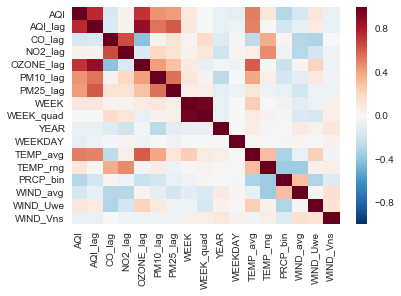

In [20]:
# Heat map
sns.heatmap(pwF.corr())

# Data Splits

In [ ]:
# Subset data into train/test and validate
pwVAL = pwF.loc[(pw.index.max() - (364)):,:] #validation
pwTT  = pwF.loc[pw.index.max() - (365*9)-1:(pw.index.max() - (365)),:] #train and test
pwTT  = pwTT.reset_index(drop=True) #Do not reset VAL index for future joining

In [ ]:
# Compare sizes and dates of files
print('Pollution:  Shape = ',pol.shape,   ', Min = ',pol.DATE.min(),   ', Max = ',pol.DATE.max())
print('Weather:    Shape = ',wea.shape,   ',Min = ',wea.DATE.min(),   ', Max = ',wea.DATE.max())
print('Poll Fore:  Shape = ',pfr.shape,   ', Min = ',pfr.DATE.min(),   ', Max = ',pfr.DATE.max())
print('Train/Test: Shape = ',pwTT.shape)
print('Validation: Shape = ',pwVAL.shape)

# Title